In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
import emoji
from nltk.tokenize.casual import TweetTokenizer
from mysql.connector import (connection)
from emoji_extractor.extract import Extractor

In [5]:
# LOADING THE DATA
# Import directly from the mySQL-database and temporarily stored in cursor
# Alternative: save data in a CSV.file

cnx = connection.MySQLConnection(user='luca', password='luca2018@imsm',
                                 charset="utf8mb4",
                                 host='db-imsm.wu.ac.at',
                                 database='twitter')

query = ("SELECT * FROM EmojiTweets WHERE text NOT LIKE '%RT_@%' AND text NOT LIKE '%HTTP%' LIMIT 10000000;")

cursor = cnx.cursor()
cursor.execute(query)

In [6]:
# TWEET BEFORE CLEANING:
tweetExample = "('tanya_az2', '@sarahdwoods @JMWVOL You are both amazing! Forget the haters. You are the best of the internet and U2 tribe! ❤️✌️🎶 You are the @PBear1979 of 2018! 🎉', 258, None, None, 'en', datetime.datetime(2018, 6, 12, 8, 37, 18))"
# TWO examples:
# print(str(cursor.next()))
print(tweetExample)

('tanya_az2', '@sarahdwoods @JMWVOL You are both amazing! Forget the haters. You are the best of the internet and U2 tribe! ❤️✌️🎶 You are the @PBear1979 of 2018! 🎉', 258, None, None, 'en', datetime.datetime(2018, 6, 12, 8, 37, 18))


In [7]:
# DELETING DUPLICATES
# Temporary fix: tweet-duplicates b/c of our crawler's many threads operating at the same time
# Storing all the string representations of all the tweets in a Set gets rid of duplicates
# This probably also mitigates the impact of bots

emojiTweetsSet = set()

for x in cursor:
    emojiTweetsSet.add(str(x))
    
cursor.close()

True

In [8]:
# PREPARING THE RAW DATA
# Objective ==> Get list of a desired selection of emojis which are then trained on
# 
# GOAL:
#     only use emojis, no other characters
#     only use emoji-sequences (len(sequence) >= 2)
#     emoji joined by a Zero Width Joiner count as one emoji (E.g.: 👮🏾, Family(👨‍👨‍👧‍👦))
#     count every emoji only once! per sequence (E.g.: "😂😂😂" ==> is not a sequence)
#     be able to extract multiple sequences if occur in a tweet
# 
# CURRENT STATUS (suboptimal):
#     thus far, I was ONLY able to extract each emoji within the tweet and form out
#     it a pseudo sequence to be able to train the model
#     I will implement the correct way of cleaning the raw-data once I know what filters work best

# extracts one copy of each emoji from a tweet
emojiExtractor = Extractor()
# TWEET EXAMPLE OUTPUT AFTER INITIAL CLEANING:
print("First cleaning: {}".format(emojiExtractor.count_emoji(tweetExample, check_first=False)))


# splits the the previously extracted emojis and puts them into a List ready for training
def extract_emojis(str):
  return ' '.join(c for c in str if c in emoji.UNICODE_EMOJI)
# TWEET EXAMPLE OUTPUT AFTER SECOND CLEANING:
print("Second cleaning: {}  <== This test code is now ready to train on.".format(extract_emojis(tweetExample).split()))

First cleaning: Counter({'❤': 1, '✌': 1, '🎶': 1, '🎉': 1})
Second cleaning: ['❤', '✌', '🎶', '🎉']  <== This test code is now ready to train on.


In [9]:
refinedTweets = list()
for x in emojiTweetsSet:
    if len(extract_emojis(emojiExtractor.count_emoji(str(x), check_first=False))) > 2:
        refinedTweets.append((extract_emojis(emojiExtractor.count_emoji(x, check_first=False))).split())

In [10]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [11]:
emoji2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [12]:
emoji2vec.build_vocab(refinedTweets)

In [13]:
print("Word2Vec vocabulary length:", len(emoji2vec.wv.vocab))
# watch out here use wv!
# why are you using wv? look that shit up!!

Word2Vec vocabulary length: 1758


In [14]:
emoji2vec.train(refinedTweets, total_examples=emoji2vec.corpus_count, epochs=8)

(17993821, 31042952)

In [15]:
if not os.path.exists("fifthAttempt"):
    os.makedirs("fifthAttempt")

In [16]:
emoji2vec.save(os.path.join("fifthAttempt", "emoji2vec.w2v"))

In [17]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [18]:
all_word_vectors_matrix = emoji2vec.wv.syn0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [19]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [20]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[emoji2vec.wv.vocab[word].index])
            for word in emoji2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [21]:
points.head(10)


,word,x,y
0,😅,4.993882,-5.941629
1,😴,7.256407,-14.983976
2,😂,7.624198,-5.346319
3,👌,3.648816,-3.251505
4,😩,4.069591,-9.057387
5,🤦🏽,7.178606,-29.622553
6,♀,12.715144,-32.600552
7,💁🏽,8.119548,-29.552355
8,🤷🏼,6.442269,-36.857872
9,♂,12.716238,-32.599495


In [22]:
sns.set_context("poster")


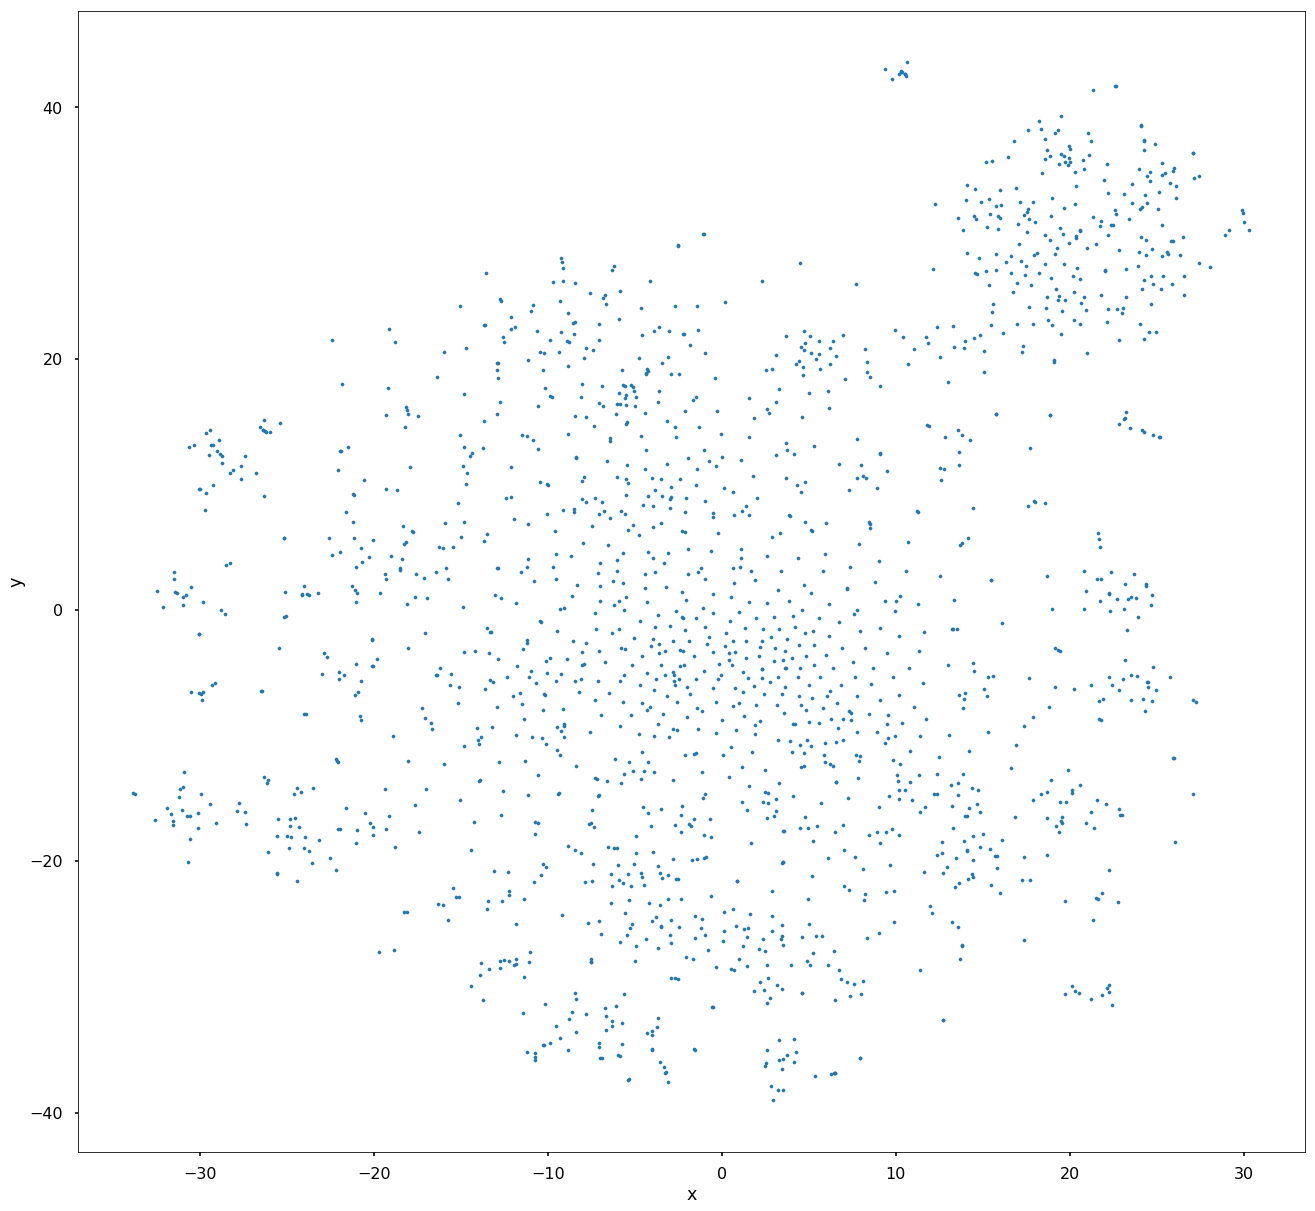

In [24]:
points.plot.scatter("x", "y", s=10, figsize=(22, 21))


In [35]:
from __future__ import unicode_literals


def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(33, 24))
    counter = 0
    for i, point in slice.iterrows():
        plt.annotate(point.word, (point.x, point.y), size=30)

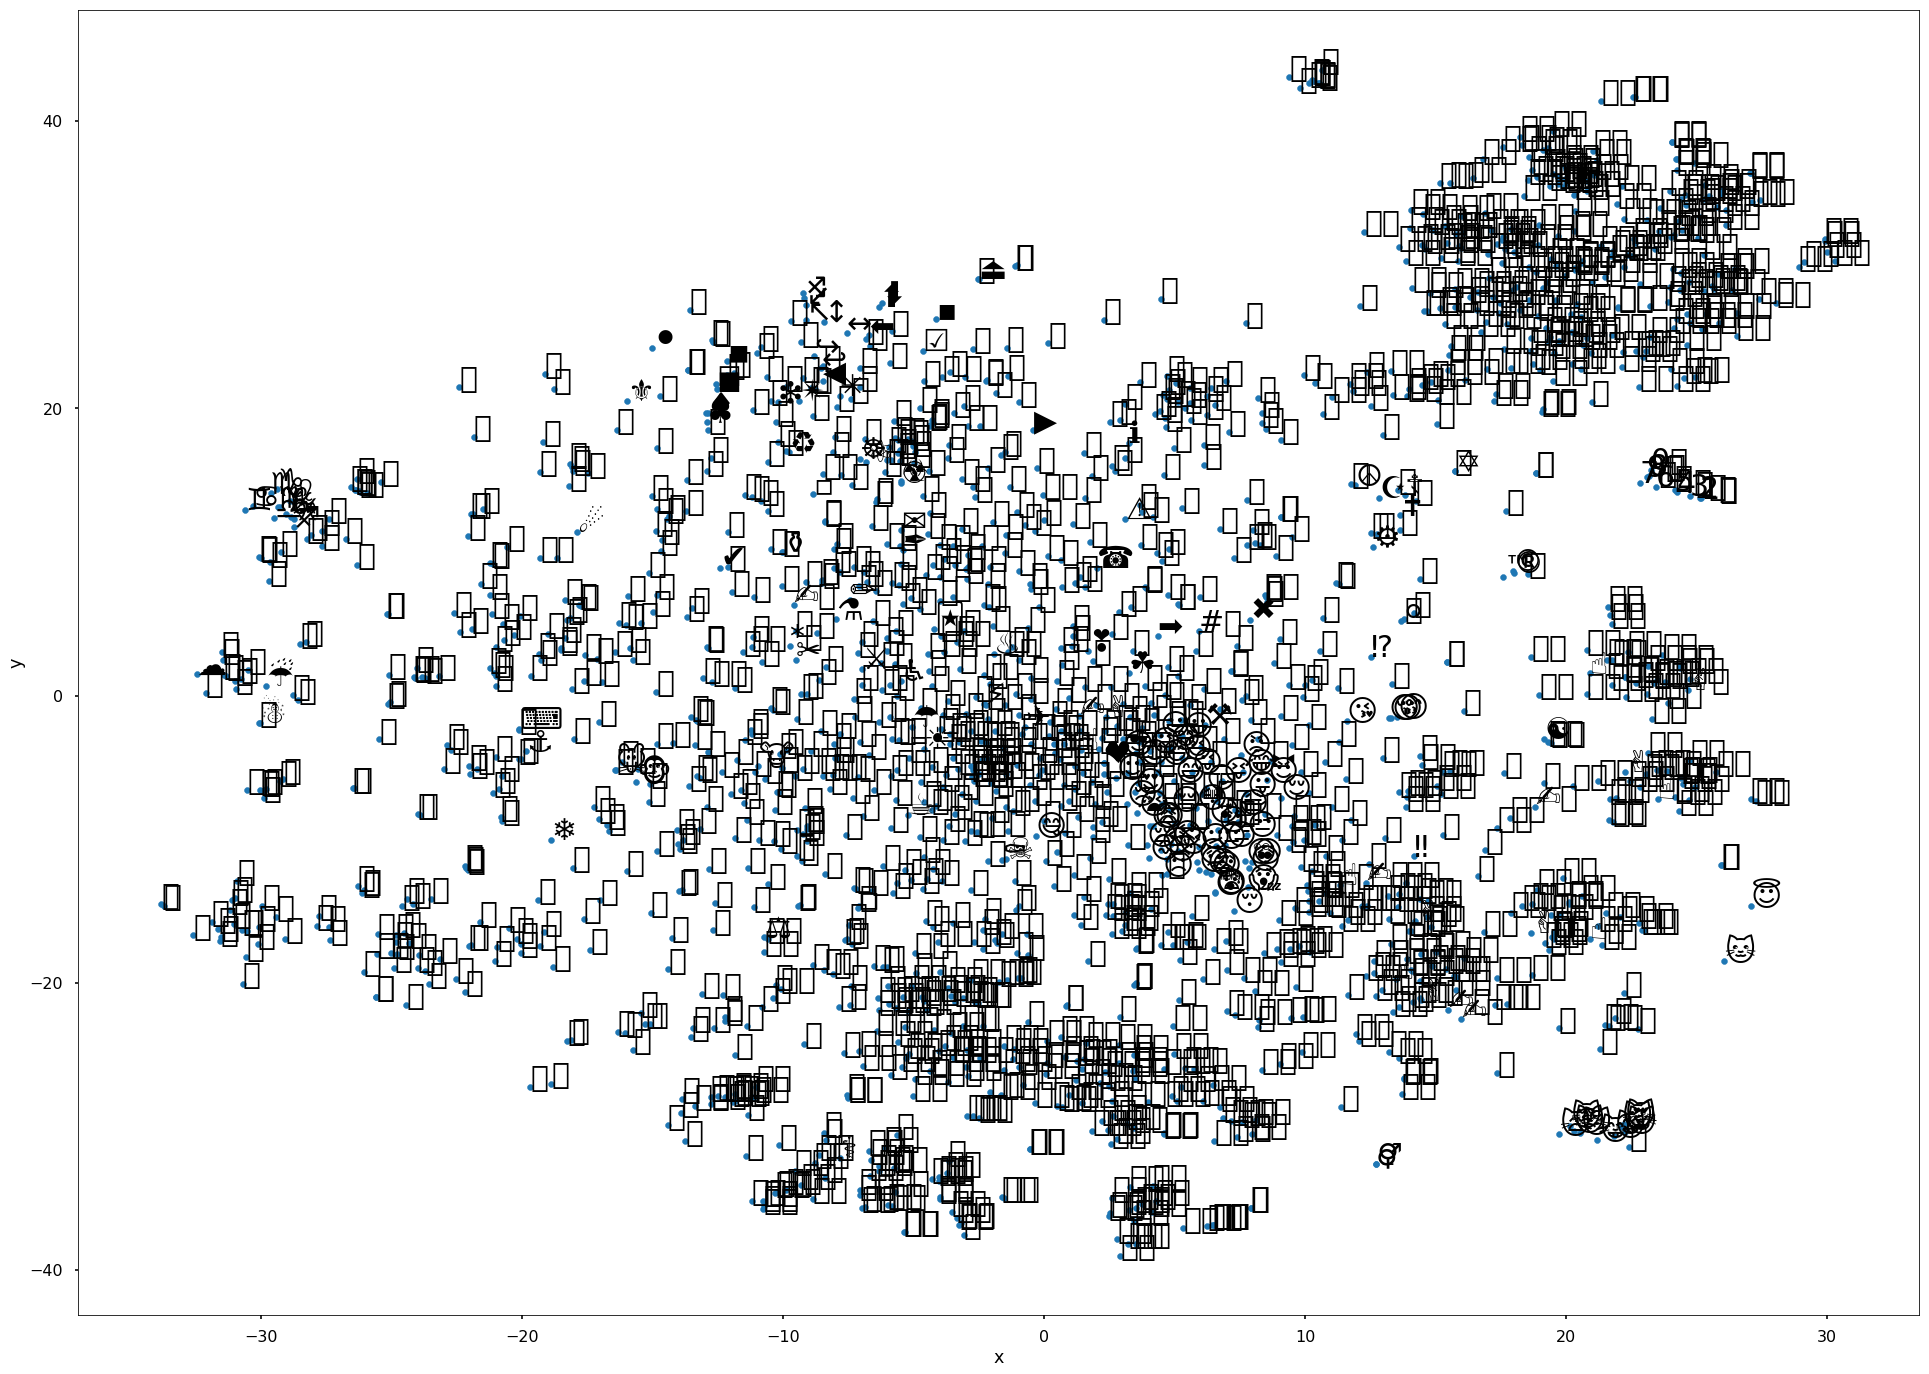

In [36]:
plot_region(x_bounds=(-100.0, 100.2), y_bounds=(-100.5, 100.1))